In [ ]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 25.1.2
    Uninstalling pyzmq-25.1.2:
      Successfully uninstalled pyzmq-25.1.2
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 8.6.1
    Uninstalling jupyter_client-8.6.1:
      Successfully uninstalled jupyter_client-8.6.1


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier # Ada=Adaptive
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier # MLP = multilayer perceptron
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
active_df = pd.read_csv("/content/active-20mm-startups-hult-project.csv") # currently active
exited_df = pd.read_csv("/content/exited-20mm-sartups-hult-project.csv") # successful
closed_df = pd.read_csv("/content/closed-startups-hult-project.csv") # unsuccessful

# Agenda

*   Currently succesful --> active and seires B, C.
*   For sure Successful --> exited_df.
*   Unsuccesfull --> closed_df.

First Step:
  Classify the active_df for the ones that are series B, C or Mezzannine (+20mln)

Step 2:
  Study patterns of successful companies

Step 3:
  Study patterns of unsuccesful companies

Step 4:
  Model to predict the Active ones that didn't reached the successful stage yet.

In [3]:
closed_df.shape


(617, 39)

In [4]:
closed_df['CB Rank (Company)']

0         58,308
1         71,915
2         73,760
3         83,563
4         88,361
         ...    
612    3,159,366
613    3,160,411
614    3,201,626
615    3,203,227
616    3,219,816
Name: CB Rank (Company), Length: 617, dtype: object

(array([153.,  61.,  29.,  33.,  22.,  22.,  20.,  21.,  14.,  10.,  11.,
          8.,   2.,  15.,  10.,   5.,  12.,   3.,   3.,   7.]),
 array([1.00000e+03, 1.50950e+05, 3.00900e+05, 4.50850e+05, 6.00800e+05,
        7.50750e+05, 9.00700e+05, 1.05065e+06, 1.20060e+06, 1.35055e+06,
        1.50050e+06, 1.65045e+06, 1.80040e+06, 1.95035e+06, 2.10030e+06,
        2.25025e+06, 2.40020e+06, 2.55015e+06, 2.70010e+06, 2.85005e+06,
        3.00000e+06]),
 <BarContainer object of 20 artists>)

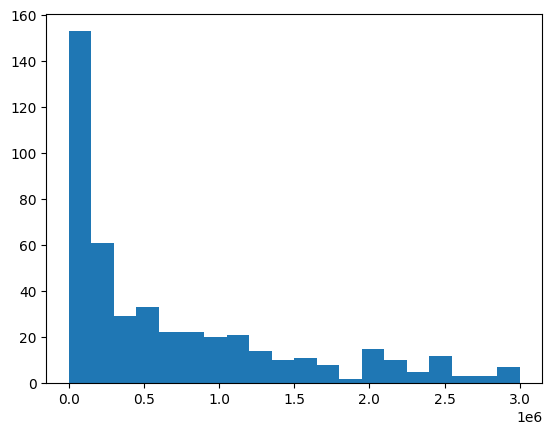

In [5]:
plt.hist(closed_df['Total Equity Funding Amount'], bins = 20)

In [6]:
more_than_3 = exited_df[exited_df['Total Funding Amount'] > 20000000]
more_than_3.shape

(318, 39)

In [7]:
exited_df.shape

(322, 39)

In [8]:
active_df.shape

(1000, 39)

In [9]:
# Overall Successful
success_df = pd.concat([active_df, exited_df])
success_df['Success'] = 1

closed_df['Success'] = 0

my_df = pd.concat([success_df, closed_df])

my_df.shape

(1939, 40)

In [10]:
my_df['Success'].sum()

1322

# Data Cleaning

In [11]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939 entries, 0 to 616
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Organization Name                              1939 non-null   object 
 1   Organization Name URL                          1939 non-null   object 
 2   Full Description                               1864 non-null   object 
 3   Founded Date                                   1892 non-null   object 
 4   Founded Date Precision                         1892 non-null   object 
 5   Number of Employees                            1800 non-null   object 
 6   Industries                                     1939 non-null   object 
 7   Headquarters Location                          1939 non-null   object 
 8   Description                                    1938 non-null   object 
 9   CB Rank (Company)                              1937 n

In [12]:
# Drop the empty columns
columns_to_drop = ['Investor Type', 'Investment Stage', 'Number of Investments',
                   'Number of Lead Investments', 'Number of Exits',
                   'Accelerator Program Type', 'Number of Exits (IPO)',
                   'Exit Date', 'Exit Date Precision']


my_df = my_df.drop(columns=columns_to_drop, errors='ignore')

In [13]:
# convert date to datetime

my_df['Founded Date'] = pd.to_datetime(my_df['Founded Date'])
my_df['Last Funding Date'] = pd.to_datetime(my_df['Last Funding Date'])

In [14]:
# Convert number of employees in numeric --> i'll the upper limit
mapping = {
    '11-50': 50,
    '51-100': 100,
    '101-250': 250,
    '1-10': 10,
    '501-1000': 1000,
    '251-500': 500,
    '5001-10000': 10000,
    '1001-5000': 5000,
    '10001+': 10001
}
my_df['Number of Employees'] = my_df['Number of Employees'].map(mapping)

In [15]:
# Remove comma in numbers fo CB rank
my_df['CB Rank (Company)'] = pd.to_numeric(my_df['CB Rank (Company)'].str.replace(',', ''), errors='coerce')

In [16]:
# Covert variables to numeric

success_df['Number of Employees'] = pd.to_numeric(success_df['Number of Employees'], errors='coerce')

In [17]:
## Same clening process for Prospects_df and Closed_df

# EDA

In [18]:
success_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 321
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Organization Name                              1322 non-null   object 
 1   Organization Name URL                          1322 non-null   object 
 2   Full Description                               1299 non-null   object 
 3   Founded Date                                   1315 non-null   object 
 4   Founded Date Precision                         1315 non-null   object 
 5   Number of Employees                            0 non-null      float64
 6   Industries                                     1322 non-null   object 
 7   Headquarters Location                          1322 non-null   object 
 8   Description                                    1322 non-null   object 
 9   CB Rank (Company)                              1320 n

In [ ]:
# Remove outliers to better visualize distribution TOTAL FUNDING

Q1 = success_df['Total Funding Amount Currency (in USD)'].quantile(0.25)
Q3 = success_df['Total Funding Amount Currency (in USD)'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to filter out outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_success_df = success_df[(success_df['Total Funding Amount Currency (in USD)'] >= lower_bound) &
                                 (success_df['Total Funding Amount Currency (in USD)'] <= upper_bound)]

(array([186., 112., 100., 132.,  97.,  85.,  66., 107.,  76.,  84.,  50.,
          4.,   8.,   1.,   3.,   9.,   6.,   1.,   2.,   5.]),
 array([20000000., 21417500., 22835000., 24252500., 25670000., 27087500.,
        28505000., 29922500., 31340000., 32757500., 34175000., 35592500.,
        37010000., 38427500., 39845000., 41262500., 42680000., 44097500.,
        45515000., 46932500., 48350000.]),
 <BarContainer object of 20 artists>)

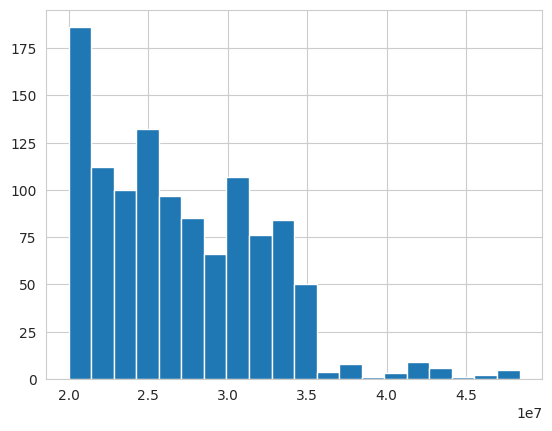

In [ ]:
plt.hist(filtered_success_df['Total Funding Amount Currency (in USD)'], bins=20)

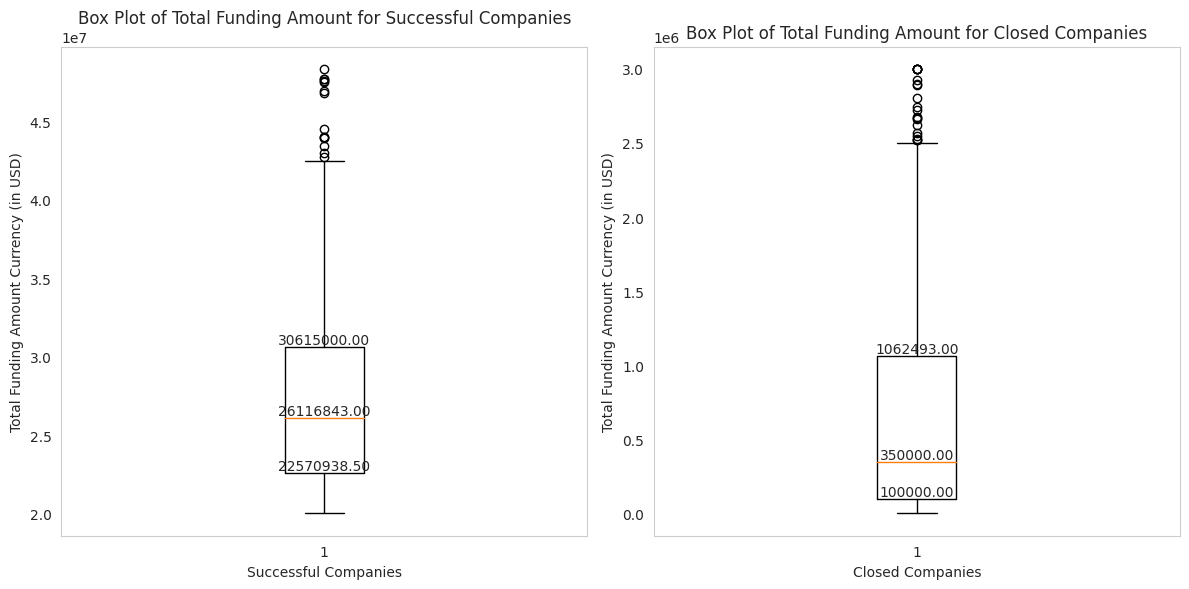

In [ ]:
# Box Plot comparison for Total Funding

# Create a figure and axis objects
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box Plot for successful companies
axes[0].boxplot(filtered_success_df['Total Funding Amount Currency (in USD)'].dropna())
axes[0].set_xlabel('Successful Companies')
axes[0].set_ylabel('Total Funding Amount Currency (in USD)')
axes[0].set_title('Box Plot of Total Funding Amount for Successful Companies')
axes[0].grid(False)

# Add labels for median, Q1, Q3
median_success = filtered_success_df['Total Funding Amount Currency (in USD)'].median()
q1_success = filtered_success_df['Total Funding Amount Currency (in USD)'].quantile(0.25)
q3_success = filtered_success_df['Total Funding Amount Currency (in USD)'].quantile(0.75)

axes[0].text(1, median_success, f'{median_success:.2f}', fontsize=10, va='bottom', ha='center')
axes[0].text(1, q1_success, f'{q1_success:.2f}', fontsize=10, va='bottom', ha='center')
axes[0].text(1, q3_success, f'{q3_success:.2f}', fontsize=10, va='bottom', ha='center')

# Box Plot for closed companies
axes[1].boxplot(closed_df['Total Funding Amount Currency (in USD)'].dropna())
axes[1].set_xlabel('Closed Companies')
axes[1].set_ylabel('Total Funding Amount Currency (in USD)')
axes[1].set_title('Box Plot of Total Funding Amount for Closed Companies')
axes[1].grid(False)

# Add labels for median, Q1, Q3
median_closed = closed_df['Total Funding Amount Currency (in USD)'].median()
q1_closed = closed_df['Total Funding Amount Currency (in USD)'].quantile(0.25)
q3_closed = closed_df['Total Funding Amount Currency (in USD)'].quantile(0.75)

axes[1].text(1, median_closed, f'{median_closed:.2f}', fontsize=10, va='bottom', ha='center')
axes[1].text(1, q1_closed, f'{q1_closed:.2f}', fontsize=10, va='bottom', ha='center')
axes[1].text(1, q3_closed, f'{q3_closed:.2f}', fontsize=10, va='bottom', ha='center')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

75% of the failing startups failed before reching $ 1 mln.

Only 5% of startups fail after receiving $ 2.5 mln of funding.

(array([176.,  80.,  33.,  35.,  25.,  29.,  21.,  22.,  14.,  12.,  10.,
         10.,   1.,  16.,  11.,   8.,  15.,   5.,   3.,   8.]),
 array([1.00000e+03, 1.50950e+05, 3.00900e+05, 4.50850e+05, 6.00800e+05,
        7.50750e+05, 9.00700e+05, 1.05065e+06, 1.20060e+06, 1.35055e+06,
        1.50050e+06, 1.65045e+06, 1.80040e+06, 1.95035e+06, 2.10030e+06,
        2.25025e+06, 2.40020e+06, 2.55015e+06, 2.70010e+06, 2.85005e+06,
        3.00000e+06]),
 <BarContainer object of 20 artists>)

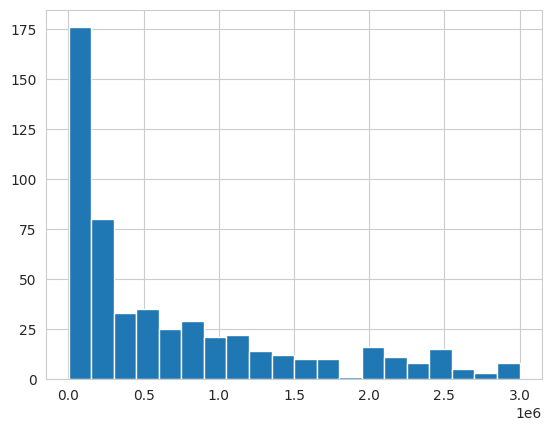

In [ ]:
plt.hist(closed_df['Total Funding Amount Currency (in USD)'], bins=20)

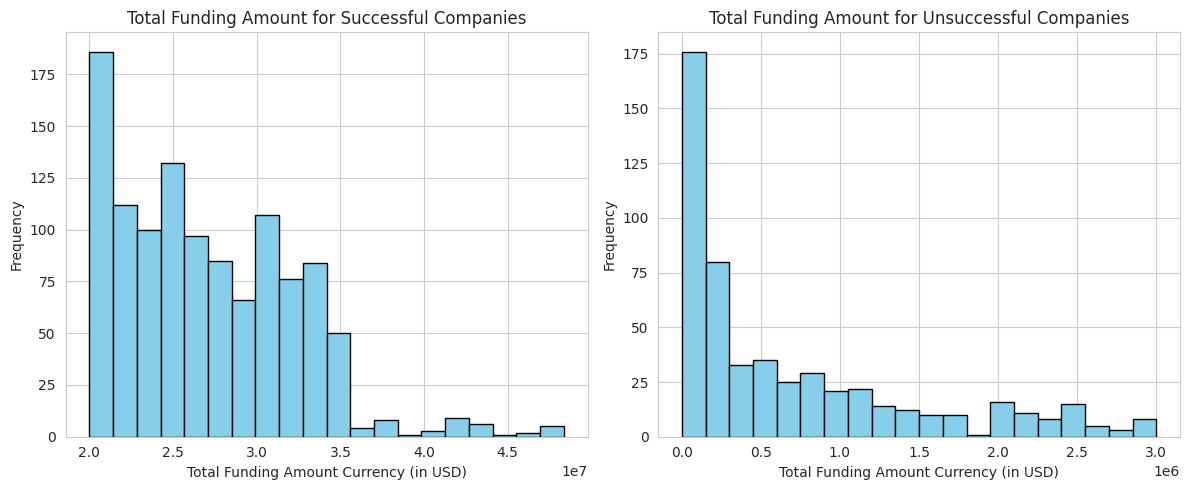

In [ ]:
## TOTAL FUNDING COMPARISON

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plotting histogram for successful companies
axes[0].hist(filtered_success_df['Total Funding Amount Currency (in USD)'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Total Funding Amount Currency (in USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Total Funding Amount for Successful Companies')

# Plotting histogram for unsuccessful (closed) companies
axes[1].hist(closed_df['Total Funding Amount Currency (in USD)'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Total Funding Amount Currency (in USD)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Total Funding Amount for Unsuccessful Companies')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Most of companies fails in the early stages, before reaching $ 500k of funds.

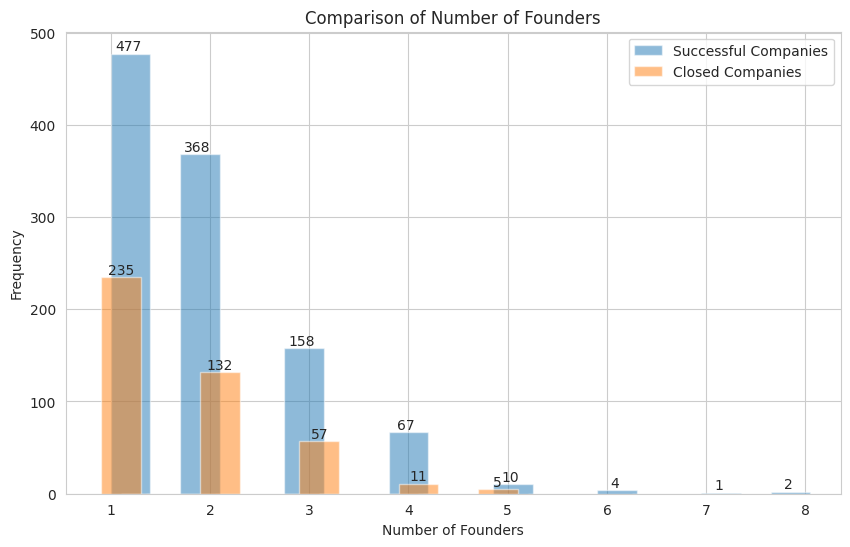

In [ ]:
# Comparing number of funders

fig, ax = plt.subplots(figsize=(10, 6))
bin_width = 0.4

success_hist, success_bins, _ = ax.hist(success_df['Number of Founders'].dropna(), bins=20, alpha=0.5, label='Successful Companies', width=bin_width, histtype='bar')
closed_hist, closed_bins, _ = ax.hist(closed_df['Number of Founders'].dropna(), bins=20, alpha=0.5, label='Closed Companies', width=bin_width, histtype='bar', align='left')

# Add labels
ax.set_xlabel('Number of Founders')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of Number of Founders')
ax.legend()

# Add labels on top of bars
for bins, hist_data, label in [(success_bins, success_hist, 'Successful Companies'), (closed_bins, closed_hist, 'Closed Companies')]:
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    for i, value in enumerate(hist_data):
        if value > 0:
            ax.text(bin_centers[i], value, str(int(value)), ha='center', va='bottom')

plt.show()


It seems that startups with multiple founders are more likely to succeed.

In [ ]:
## Time Analysis

In [ ]:
failed_month_counts = closed_df['Founded Date'].dt.strftime('%Y').value_counts().reset_index()
failed_month_counts.columns = ['Date', 'Count_failed']

founded_month_counts = success_df['Founded Date'].dt.strftime('%Y').value_counts().reset_index()
founded_month_counts.columns = ['Date', 'Count_founded']

# Join failed and succeed count per month
count_monthly = founded_month_counts.set_index('Date').join(failed_month_counts.set_index('Date'),
                                                            how='left',
                                                            lsuffix='_founded',
                                                            rsuffix='_failed').fillna(0) # Transform Nulls in 0

count_monthly['Tot Count'] = count_monthly['Count_founded'] + count_monthly['Count_failed']

# Success Rate
count_monthly['Success_rate'] = count_monthly['Count_founded'] / count_monthly['Tot Count']

# Sort for Date
count_monthly = count_monthly.sort_index()

# % of failed and % of success
count_monthly['success_pct'] = count_monthly['Count_founded'] / count_monthly['Tot Count']
count_monthly['failed_pct'] = count_monthly['Count_failed'] / count_monthly['Tot Count']

count_monthly.info()

AttributeError: Can only use .dt accessor with datetimelike values

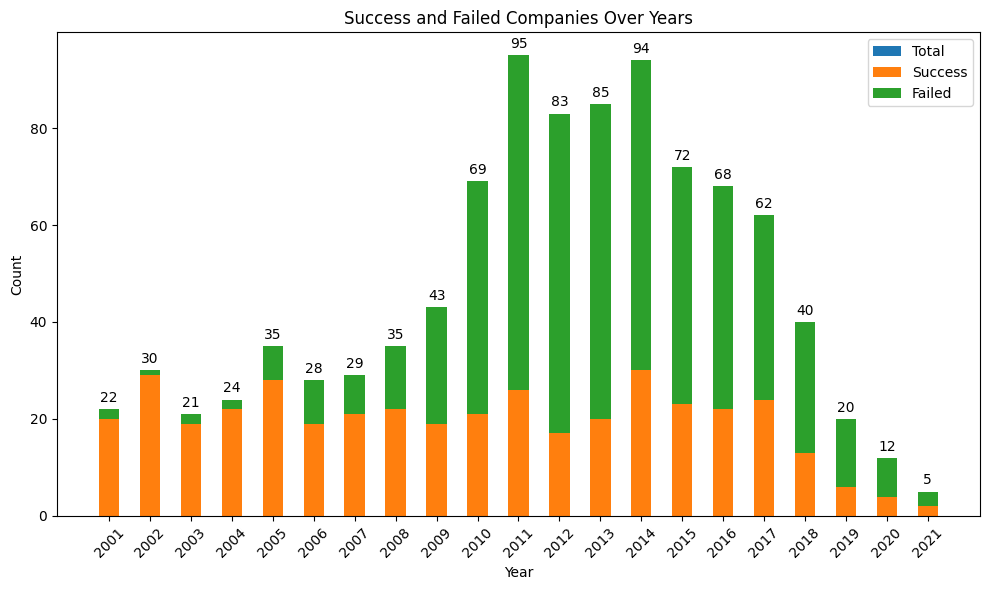

In [ ]:
# Filter the data starting from 2001
count_monthly_filtered = count_monthly[count_monthly.index >= '2001']

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
total_bars = ax.bar(count_monthly_filtered.index, count_monthly_filtered['Tot Count'], bar_width, label='Total')
success_bars = ax.bar(count_monthly_filtered.index, count_monthly_filtered['Count_founded'], bar_width, label='Success', bottom=0)
failed_bars = ax.bar(count_monthly_filtered.index, count_monthly_filtered['Count_failed'], bar_width, label='Failed', bottom=count_monthly_filtered['Count_founded'])

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Success and Failed Companies Over Years')
ax.legend()

# Rotate x-ticks for better visibility
plt.xticks(count_monthly_filtered.index, rotation=45)


# Annotate total count on top of total bars
for bar in total_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
success_df['Founded Date']

6     2012-01-01
7     2013-01-01
9     2014-01-01
12    2012-01-01
13    2017-01-01
         ...    
317   1996-01-01
318   1999-01-01
319   2008-01-01
320   1997-01-01
321   2006-01-01
Name: Founded Date, Length: 543, dtype: datetime64[ns]

In [ ]:
active_df['Investment Stage'].unique()

array([nan, 'Early Stage Venture, Seed', 'Early Stage Venture'],
      dtype=object)

In [ ]:
active_df['Last Funding Type'].unique()

array(['Series A', 'Seed', 'Series B', 'Convertible Note',
       'Private Equity', 'Series C', 'Venture - Series Unknown',
       'Debt Financing', 'Grant', 'Corporate Round', 'Series D',
       'Undisclosed', 'Non-equity Assistance', 'Angel', 'Series F',
       'Series E', 'Secondary Market'], dtype=object)

In [ ]:
# Total Funding per Funding Type -- we are interested in 'Series B'
funding_type_df = active_df.groupby('Last Funding Type')['Total Funding Amount Currency (in USD)'].sum()
funding_type_df = funding_type_df.sort_values(ascending=False)

Text(0.5, 1.0, 'Total Funding Amount by Last Funding Type')

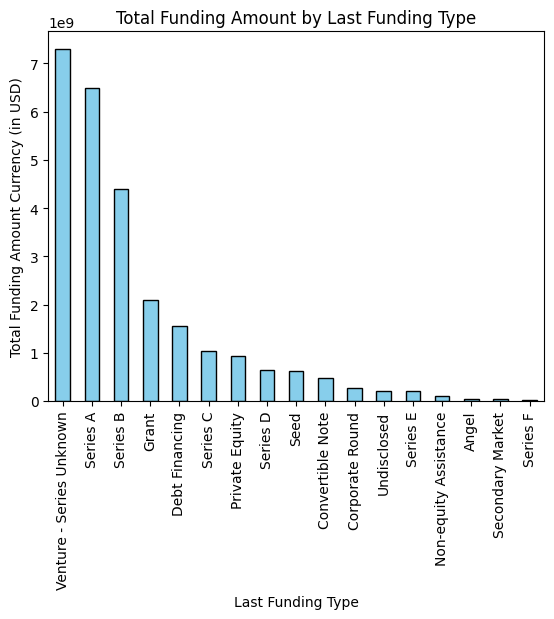

In [ ]:
# Plotting the bar chart
funding_type_df.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Last Funding Type')
plt.ylabel('Total Funding Amount Currency (in USD)')
plt.title('Total Funding Amount by Last Funding Type')

Text(0.5, 1.0, 'Number of Active and Closed Companies')

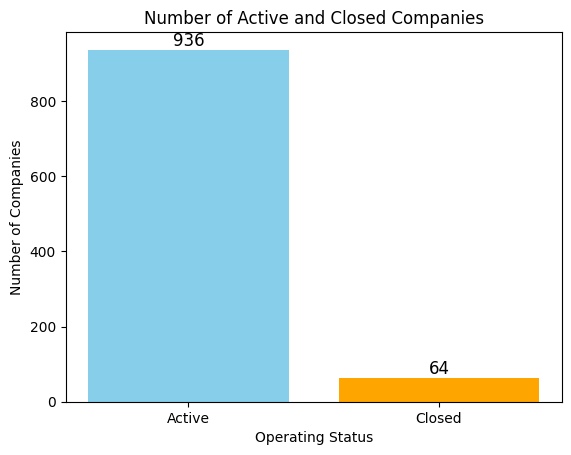

In [ ]:
# Converting 'Founded Date' to datetime format (if not already)
active_df['Founded Date'] = pd.to_datetime(active_df['Founded Date'])

# Filter for Active and Closed
active_companies = active_df[active_df['Operating Status'] == 'Active']

closed_companies = active_df[active_df['Operating Status'] == 'Closed']

# Counting the number of Active and Closed companies
active_count = active_companies.shape[0]
closed_count = closed_companies.shape[0]

# Plotting the bar chart
plt.bar(['Active', 'Closed'], [active_count, closed_count], color=['skyblue', 'orange'])

# Adding labels to the bars
plt.text(0, active_count, str(active_count), ha='center', va='bottom', fontsize=12, color='black')
plt.text(1, closed_count, str(closed_count), ha='center', va='bottom', fontsize=12, color='black')

# Adding labels and title
plt.xlabel('Operating Status')
plt.ylabel('Number of Companies')
plt.title('Number of Active and Closed Companies')

Text(0.5, 1.0, 'Number of Companies Founded Over Time')

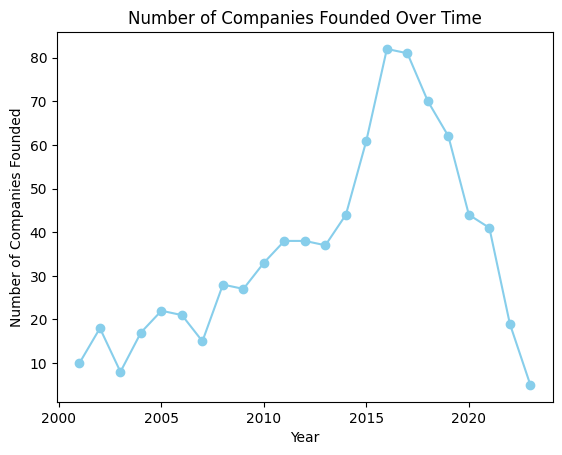

In [ ]:
# Time series of Acitve companies

# Filtering for companies founded after the year 2000
active_companies_filtered = active_companies[active_companies['Founded Date'].dt.year > 2000]

# Counting the number of companies founded each year
founded_counts = active_companies_filtered['Founded Date'].dt.year.value_counts().sort_index()

# Plotting the line chart
plt.plot(founded_counts.index, founded_counts.values, marker='o', color='skyblue', linestyle='-')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Companies Founded')
plt.title('Number of Companies Founded Over Time')

Text(0.5, 1.0, 'Number of Companies Founded Over Time')

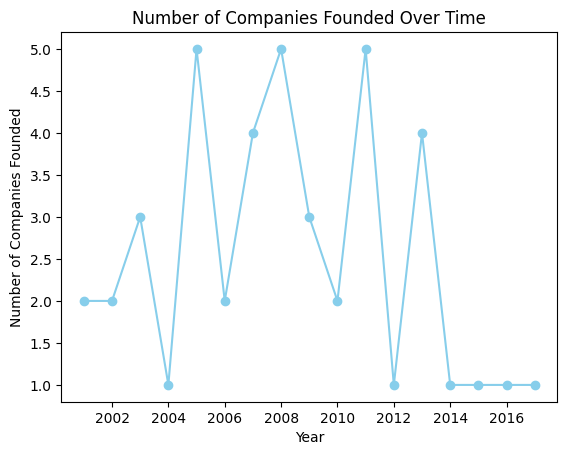

In [ ]:
# Time series of Closed companies

# Filtering for companies founded after the year 2000
closed_companies_filtered = closed_companies[closed_companies['Founded Date'].dt.year > 2000]

# Counting the number of companies founded each year
founded_closed_counts = closed_companies_filtered['Founded Date'].dt.year.value_counts().sort_index()

# Plotting the line chart
plt.plot(founded_closed_counts.index, founded_closed_counts.values, marker='o', color='skyblue', linestyle='-')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Companies Founded')
plt.title('Number of Companies Founded Over Time')

In [ ]:
## Success rate across time
## Location patterns

In [ ]:
active_df['Operating Status'].unique()

array(['Active', 'Closed'], dtype=object)

In [ ]:
# List of columns to drop
col_drop = ['Investor Type', 'Investment Stage', 'Number of Investments',
            'Number of Lead Investments', 'Number of Exits', 'Exit Date',
            'Exit Date Precision']

# Drop the specified columns
closed_companies = closed_companies.drop(columns=col_drop)

In [ ]:
closed_companies.describe()

,Accelerator Program Type,Number of Exits (IPO),Number of Founders,Number of Funding Rounds,Last Funding Amount,Last Funding Amount Currency (in USD),Last Equity Funding Amount,Last Equity Funding Amount Currency (in USD),Total Equity Funding Amount,Total Equity Funding Amount Currency (in USD),Total Funding Amount,Total Funding Amount Currency (in USD)
count,0.0,1.0,41.000000,64.000000,6.400000e+01,6.400000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.400000e+01,6.400000e+01
mean,NaN,1.0,1.682927,2.921875,1.537503e+07,1.550254e+07,1.649480e+07,1.662642e+07,2.555929e+07,2.569091e+07,2.679286e+07,2.692037e+07
std,NaN,NaN,0.819726,2.155132,1.083017e+07,1.099211e+07,9.911333e+06,1.007890e+07,5.755879e+06,5.835634e+06,4.593333e+06,4.655619e+06
min,NaN,1.0,1.000000,1.000000,5.500000e+04,5.500000e+04,1.000000e+06,1.000000e+06,2.105265e+06,2.105265e+06,2.000000e+07,2.000000e+07
25%,NaN,1.0,1.000000,1.000000,3.293060e+06,3.293060e+06,7.575000e+06,7.575000e+06,2.143375e+07,2.143375e+07,2.240132e+07,2.240132e+07
50%,NaN,1.0,1.000000,2.000000,1.872375e+07,1.872375e+07,2.000000e+07,2.000000e+07,2.495138e+07,2.495138e+07,2.750845e+07,2.763566e+07
75%,NaN,1.0,2.000000,4.000000,2.435000e+07,2.435000e+07,2.397500e+07,2.397500e+07,3.054722e+07,3.089907e+07,3.044907e+07,3.069722e+07
max,NaN,1.0,4.000000,10.000000,3.400000e+07,3.400000e+07,3.400000e+07,3.400000e+07,3.459125e+07,3.459125e+07,3.459125e+07,3.459125e+07


# Stage of life of successful and unsuccessful

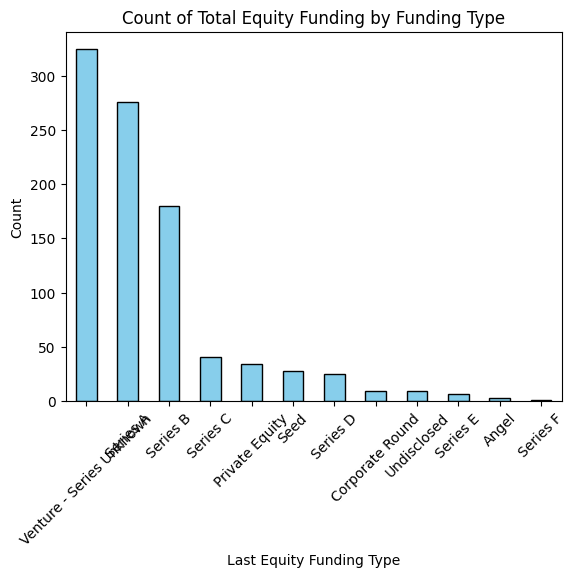

In [ ]:
active_grouped = active_df.groupby('Last Equity Funding Type')['Total Equity Funding Amount Currency (in USD)'].count()
active_grouped = active_grouped.sort_values(ascending=False)

# Plotting the bar plot
active_grouped.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Last Equity Funding Type')
plt.ylabel('Count')
plt.title('Count of Total Equity Funding by Funding Type')

# Rotating x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Showing the plot
plt.show()

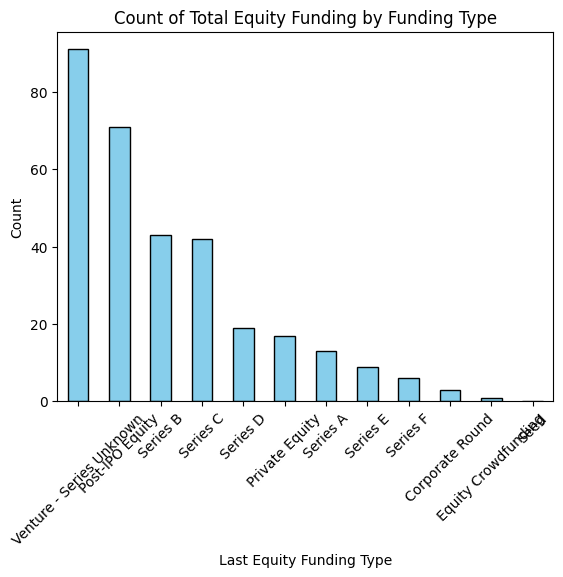

In [ ]:
exited_grouped = exited_df.groupby('Last Equity Funding Type')['Total Equity Funding Amount Currency (in USD)'].count()
exited_grouped = exited_grouped.sort_values(ascending=False)

# Plotting the bar plot
exited_grouped.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Last Equity Funding Type')
plt.ylabel('Count')
plt.title('Count of Total Equity Funding by Funding Type')

# Rotating x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Showing the plot
plt.show()

In [ ]:
unknown_series = active_df[active_df['Last Equity Funding Type'] == 'Venture - Series Unknown']
unknown_series['Last Equity Funding Type']

15     Venture - Series Unknown
16     Venture - Series Unknown
19     Venture - Series Unknown
24     Venture - Series Unknown
25     Venture - Series Unknown
                 ...           
979    Venture - Series Unknown
988    Venture - Series Unknown
992    Venture - Series Unknown
998    Venture - Series Unknown
999    Venture - Series Unknown
Name: Last Equity Funding Type, Length: 325, dtype: object

# Feature Engineering

<ipython-input-19-8e629b501a69>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = my_df.corr()


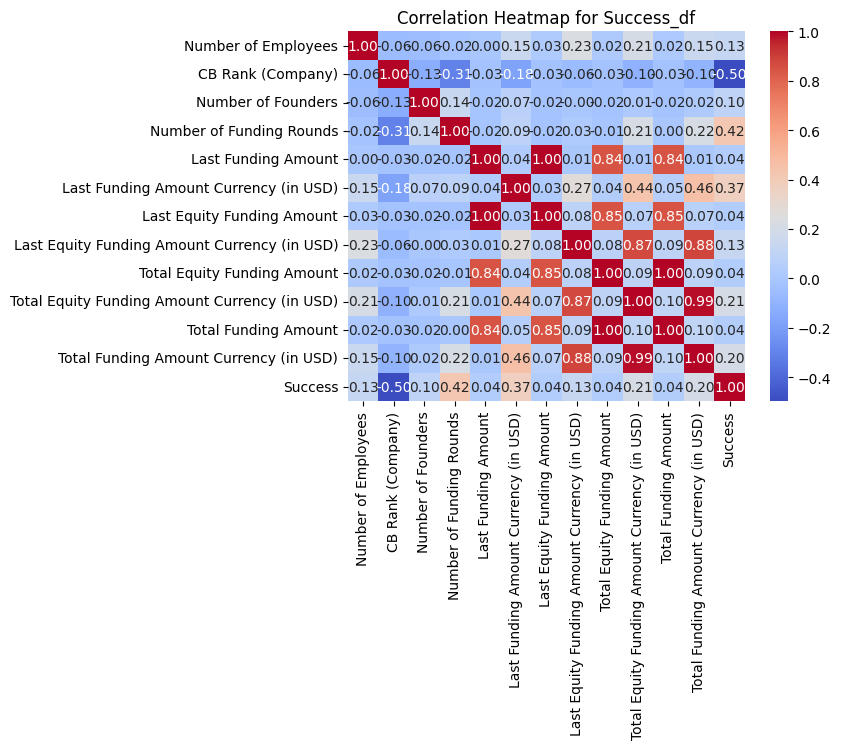

In [19]:
# Create a correlation matrix
corr_matrix = my_df.corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and show the plot
plt.title('Correlation Heatmap for Success_df')
plt.show()


In [20]:
# Columns to drop:
columns_to_drop = ['Total Funding Amount', 'Total Equity Funding Amount', 'Last Equity Funding Amount', 'Total Funding Amount Currency (in USD)', 'Total Equity Funding Amount Currency (in USD)']
my_df = my_df.drop(columns=columns_to_drop)

<ipython-input-21-5bc2220ec0ae>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_2 = my_df.corr()


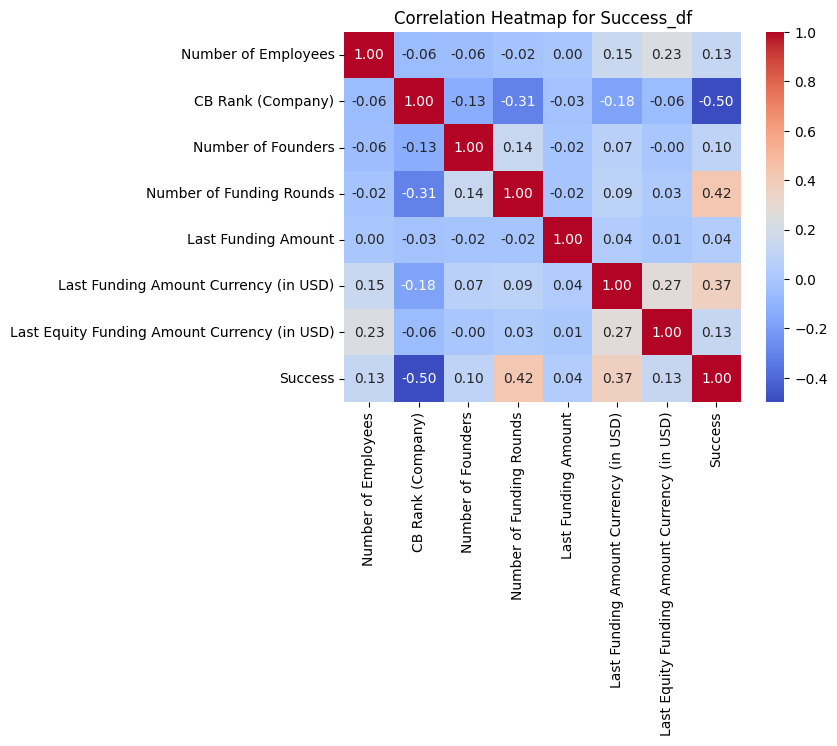

In [21]:
# Create a correlation matrix
corr_matrix_2 = my_df.corr()

# Generate a heatmap
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")

# Add title and show the plot
plt.title('Correlation Heatmap for Success_df')
plt.show()

In [22]:
my_df.shape

(1939, 26)

In [23]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939 entries, 0 to 616
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Organization Name                             1939 non-null   object        
 1   Organization Name URL                         1939 non-null   object        
 2   Full Description                              1864 non-null   object        
 3   Founded Date                                  1892 non-null   datetime64[ns]
 4   Founded Date Precision                        1892 non-null   object        
 5   Number of Employees                           1800 non-null   float64       
 6   Industries                                    1939 non-null   object        
 7   Headquarters Location                         1939 non-null   object        
 8   Description                                   1938 non-null   object 

In [24]:
## Handle Industry Column

industries_split = my_df['Industries'].str.split(', ', expand=True)

industries_split.head()

#my_df = pd.concat([my_df, industries_split])

#my_df.info()

,0,1,2,3,4,5,6,7,8,9
0,Employee Benefits,Human Resources,SaaS,Software,None,None,None,None,None,None
1,Health Care,Mental Health,mHealth,Therapeutics,Wellness,None,None,None,None,None
2,Employee Benefits,Employment,Gamification,Hospitality,Software,None,None,None,None,None
3,Health Care,Information Technology,Software,None,None,None,None,None,None,None
4,Continuing Education,E-Learning,EdTech,Elder Care,Information Technology,Virtual Workforce,None,None,None,None


In [25]:
# Convert the DataFrame to a Series
industries_series = industries_split.stack()

# Drop the NaN values
industries_series = industries_series.dropna()

# Convert the Series to a list
industries_vector = industries_series.tolist()

# Remove duplicates from the list
industries_vector = list(set(industries_vector))

# Create Dataframe with Column Names
new_df = pd.DataFrame(columns=industries_vector)

In [26]:
# Concatenate the new_df with the original my_df
result_df = pd.concat([my_df, new_df], axis=1)

# Iterate through each row of the result_df
for index, row in result_df.iterrows():
    # Get the list of industries for the current row
    industries = row['Industries'].split(', ')

    # Iterate through each column in the new_df
    for col in new_df.columns:
        # Check if the column name is present in the list of industries
        if col in industries:
            # Set the value to 1 if present
            result_df.at[index, col] = 1
        else:
            # Set the value to 0 if not present
            result_df.at[index, col] = 0

# Convert the columns to numeric
result_df[new_df.columns] = result_df[new_df.columns].apply(pd.to_numeric)

In [27]:
result_df.shape

(1939, 347)

In [28]:
column = ['Success']
result_df_numeric = result_df.drop(columns = column)
result_df_numeric.shape

# Keep numeric
result_df_numeric = result_df_numeric.select_dtypes(include='number')
result_df_numeric.shape

(1939, 328)

# Models

In [29]:
X = result_df_numeric
X = X.fillna(0)
y = result_df['Success']

In [30]:
X.head()

,Number of Employees,CB Rank (Company),Number of Founders,Number of Funding Rounds,Last Funding Amount,Last Funding Amount Currency (in USD),Last Equity Funding Amount Currency (in USD),Developer Platform,Automotive,CRM,...,Legal,Sharing Economy,Subscription Service,Consumer Research,Accounting,Loyalty Programs,Cloud Computing,Retirement,Food Trucks,Outpatient Care
0,250.0,4331.0,2.0,2,20000000.0,20000000.0,20000000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50.0,5462.0,2.0,1,20000000.0,20000000.0,20000000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,50.0,6586.0,1.0,3,12000000.0,12000000.0,12000000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50.0,7113.0,2.0,2,15000000.0,15000000.0,15000000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100.0,8424.0,2.0,4,10000000.0,10000000.0,10000000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [32]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1551, 328) (388, 328) (1551,) (388,)


## Logistic Regression

In [33]:
from sklearn.metrics import confusion_matrix

# Create and train the logistic regression model
model = LogisticRegression(multi_class='auto', max_iter=1000)  # Using default parameters
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_logreg)

# Additional evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9226804123711341
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       128
           1       0.94      0.95      0.94       260

    accuracy                           0.92       388
   macro avg       0.91      0.91      0.91       388
weighted avg       0.92      0.92      0.92       388

Confusion Matrix:
[[112  16]
 [ 14 246]]


## XG Boost

In [80]:
# Initialize and train the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_xgb:.2f}")

# Generate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_xgb)


# Save the XGBoost model
xgb_clf.save_model('xgboost_model.txt')

Accuracy: 0.98
Confusion Matrix:
[[124   4]
 [  2 258]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:14:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [79]:
#X.info(verbose=True)

# User Input

In [97]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Retrain the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Create a function to add the XGBoost prediction to the new_df
def add_prediction(df):
    # Make a prediction using the XGBoost model
    proba = xgb_clf.predict_proba(df)
    # Print the probability of success
    print('Probability of success:', proba[:, 1][0])

# Create a new dataframe with the same columns as the original dataset and a first row of zeros
new_df = pd.DataFrame(0, index=[0], columns=X.columns)

# Create a HBox to display the text boxes and their descriptions side by side
text_boxes = [widgets.FloatText(value=0, layout=widgets.Layout(width='100px')) for _ in range(7)]
text_box_widgets = [
    widgets.HBox([widgets.Label(value=X.columns[i], layout=widgets.Layout(width='200px')), text_box])
    for i, text_box in enumerate(text_boxes)
]

# Create a dropdown menu with a search bar
dropdown = widgets.Dropdown(
    options=X.columns[7:],
    value=None,
    disabled=False,
    multiple=True,
    layout=widgets.Layout(width='400px')
)

search_bar = widgets.Text(
    value='',
    placeholder='Search industry',
    continuous_update=False,
    layout=widgets.Layout(width='200px')
)

dropdown_with_search = widgets.VBox([search_bar, dropdown])

# Create a function to filter the dropdown options
def filter_options(search_text):
    filtered_options = [option for option in X.columns[7:] if search_text.lower() in option.lower()]
    dropdown.options = filtered_options

# Connect the search bar to the filter function
search_bar.observe(lambda change: filter_options(change.new), names='value')

# Create an HBox to display the dropdown menu and its description
dropdown_box = widgets.HBox([
    widgets.Label(value='Select features:', layout=widgets.Layout(width='150px')),
    dropdown_with_search
])

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Create a function to display the updated table
def on_button_clicked(b):
    display(new_df)
    # Add the XGBoost prediction to the new_df
    add_prediction(new_df)

# Connect the function to the button
submit_button.on_click(on_button_clicked)

# Create a function to update the new dataframe when the dropdown menu selection changes
def on_dropdown_change(change):
    selected_options = change['new']
    for col in X.columns[7:]:
        if col in selected_options:
            new_df.loc[0, col] = 1
        else:
            new_df.loc[0, col] = 0

# Connect the function to the dropdown menu
dropdown.observe(on_dropdown_change, names='value')

# Create a function to update the new dataframe when the text boxes change
def on_text_change(change):
    for i, text_box in enumerate(text_boxes):
        new_df.iloc[0, i] = text_box.value

# Connect the function to the text boxes
for text_box in text_boxes:
    text_box.observe(on_text_change, names='value')

# Display the input widgets
display(*text_box_widgets, dropdown_box, submit_button)

Button(description='Submit', style=ButtonStyle())

,Number of Employees,CB Rank (Company),Number of Founders,Number of Funding Rounds,Last Funding Amount,Last Funding Amount Currency (in USD),Last Equity Funding Amount Currency (in USD),Developer Platform,Automotive,CRM,...,Legal,Sharing Economy,Subscription Service,Consumer Research,Accounting,Loyalty Programs,Cloud Computing,Retirement,Food Trucks,Outpatient Care
0,10,100234,2,5,1000000,1000000,1000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Probability of success: 0.8459245


In [92]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Retrain the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Create a function to add the XGBoost prediction to the new_df
def add_prediction(df):
    # Make a prediction using the XGBoost model
    proba = xgb_clf.predict_proba(df)
    # Print the probability of success
    print('Probability of success:', proba[:, 1][0])

# Create a new dataframe with the same columns as the original dataset and a first row of zeros
new_df = pd.DataFrame(0, index=[0], columns=X.columns)

# Create a HBox to display the text boxes and their descriptions side by side
text_boxes = [widgets.FloatText(value=0, layout=widgets.Layout(width='100px')) for _ in range(7)]
text_box_widgets = [
    widgets.HBox([widgets.Label(value=X.columns[i], layout=widgets.Layout(width='200px')), text_box])
    for i, text_box in enumerate(text_boxes)
]

# Create a dropdown menu for the remaining columns
dropdown = widgets.Dropdown(
    options=X.columns[7:],
    value=None,
    disabled=False,
    multiple=True,
    layout=widgets.Layout(width='400px')
)

# Create an HBox to display the dropdown menu and its description
dropdown_box = widgets.HBox([
    widgets.Label(value='Select Industries:', layout=widgets.Layout(width='150px')),
    dropdown
])

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Create a function to display the updated table
def on_button_clicked(b):
    display(new_df)
    # Add the XGBoost prediction to the new_df
    add_prediction(new_df)

# Connect the function to the button
submit_button.on_click(on_button_clicked)

# Create a function to update the new dataframe when the dropdown menu selection changes
def on_dropdown_change(change):
    selected_options = change['new']
    for col in X.columns[7:]:
        if col in selected_options:
            new_df.loc[0, col] = 1
        else:
            new_df.loc[0, col] = 0

# Connect the function to the dropdown menu
dropdown.observe(on_dropdown_change, names='value')

# Create a function to update the new dataframe when the text boxes change
def on_text_change(change):
    for i, text_box in enumerate(text_boxes):
        new_df.iloc[0, i] = text_box.value

# Connect the function to the text boxes
for text_box in text_boxes:
    text_box.observe(on_text_change, names='value')

# Display the input widgets
display(*text_box_widgets, dropdown_box, submit_button)

Button(description='Submit', style=ButtonStyle())

In [93]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Retrain the XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Create a function to add the XGBoost prediction to the new_df
def add_prediction(df):
    # Make a prediction using the XGBoost model
    proba = model.predict_proba(df)

    # Print the probability of success
    print('Probability of success:', proba[:, 1][0])

# Create a new dataframe with the same columns as the original dataset and a first row of zeros
new_df = pd.DataFrame(0, index=[0], columns=X.columns)

# Create text boxes for the first 8 columns
text_boxes = [widgets.FloatText(description=X.columns[i], disabled=False, value=0) for i in range(7)]

# Create a dropdown menu for the remaining columns
dropdown = widgets.Dropdown(
    options=X.columns[7:],
    value=None,
    description='Select features:',
    disabled=False,
    multiple=True
)

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Create a function to display the updated table
def on_button_clicked(b):
    display(new_df)
    # Add the XGBoost prediction to the new_df
    add_prediction(new_df)


# Connect the function to the button
submit_button.on_click(on_button_clicked)

# Create a function to update the new dataframe when the dropdown menu selection changes
def on_dropdown_change(change):
    selected_options = change['new']
    for col in X.columns[7:]:
        if col in selected_options:
            new_df.loc[0, col] = 1
        else:
            new_df.loc[0, col] = 0

# Connect the function to the dropdown menu
dropdown.observe(on_dropdown_change, names='value')

# Create a function to update the new dataframe when the text boxes change
def on_text_change(change):
    for i, text_box in enumerate(text_boxes):
        new_df.iloc[0, i] = text_box.value

# Connect the function to the text boxes
for text_box in text_boxes:
    text_box.observe(on_text_change, names='value')

# Display the input widgets
display(widgets.HBox(text_boxes))
display(dropdown)
display(submit_button)

Dropdown(description='Select features:', options=('Developer Platform', 'Automotive', 'CRM', 'EdTech', 'Clinic…

Button(description='Submit', style=ButtonStyle())